In [58]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import quantstats as qs
qs.extend_pandas()
from joblib import Parallel, delayed
import requests
from IPython.display import display

path = os.getcwd()
print(path)
#BTC = pd.read_csv(path+'/BTC_insmaple_data.csv',index_col=0,parse_dates=True)
#BTC = pd.read_csv(path+'/btc_outsample.csv',index_col=0,parse_dates=True)
BTC_insample = pd.read_csv(path+'/BTC_insmaple_data.csv',index_col=0,parse_dates=True)
BTC_outsample = pd.read_csv(path+'/btc_outsample.csv',index_col=0,parse_dates=True)
BTC = pd.concat([BTC_insample,BTC_outsample]).drop_duplicates()
price_df = BTC['Close'].resample('15min').last()



c:\Users\xiuhu\OneDrive\桌面\py\quant


In [59]:
def get_EMA(price_df,period):
    EMA = price_df.ewm(span=period,min_periods = period//2).mean()
    return EMA
def get_SMA(price_df,period):
    SMA = price_df.rolling(window = period, min_periods= period//2).mean()
    return SMA

In [56]:
#%%time

EMA_df = pd.concat(Parallel(n_jobs=-2)(delayed(get_EMA)(price_df,period) for period in range(10,501,10)),axis = 1).ffill()
EMA_df.columns = range(10,501,10)
SMA_df = pd.concat(Parallel(n_jobs=-2)(delayed(get_SMA)(price_df,period) for period in range(10,501,10)),axis = 1).ffill()
SMA_df.columns = range(10,501,10)



In [60]:
EMA_480_df = get_EMA(price_df,480)
SMA_480_df = get_SMA(price_df,480)
EMA_3070_df = get_EMA(price_df,3070)
SMA_3070_df = get_SMA(price_df,3070)
long_480 = EMA_480_df>=SMA_480_df
long_3070 = EMA_3070_df>=SMA_3070_df
short_entries = EMA_3070_df < SMA_3070_df
short_exits = EMA_3070_df > SMA_3070_df
long = long_480 + long_3070
short_480 = EMA_480_df<SMA_3070_df
short_3070 = EMA_3070_df<SMA_3070_df
short = short_480 + short_3070


In [68]:
pf_short = vbt.Portfolio.from_signals(price_df.shift(-1),
                                short_entries = short_entries,
                                short_exits = short_exits,                           
                                #short_entries = EMA_df<SMA_df,
                                #short_exits = EMA_df>SMA_df,
                                fees = 0.0015)
pf_ret_short = pf_short.returns()

In [59]:
#pf_ret_short.sharpe().idxmax()
#pf_ret_short.sharpe().plot()

In [69]:
pf_1 = vbt.Portfolio.from_signals(price_df.shift(-1),
                                #entries = EMA_df >= SMA_df,
                                #exits = EMA_df < SMA_df,
                                entries = long_480,
                                exits = short_480,
                                fees = 0.0015)
pf_ret_1 = pf_1.returns()


In [61]:
#print(pf_ret_1.sharpe().idxmax())
#pf_ret_1.sharpe().plot()

In [70]:
pf_2 = vbt.Portfolio.from_signals(price_df.shift(-1),
                                entries = long_3070,
                                exits = short_3070,
                                fees = 0.0015)
pf_ret_2 = pf_2.returns()

In [71]:
#combine long short
long_strat = 0.4*pf_ret_1 + pf_ret_2*0.4
rolling_std = long_strat.rolling(72).std()
w_se = (1/rolling_std)/(1/rolling_std).rolling(72).mean()
long_strat = long_strat*(w_se.shift(1))
short_strat = 0.2*pf_ret_short
Strategy_ret = long_strat + short_strat

In [57]:
rett = Strategy_ret.to_frame()
day_rett = rett.resample("1D").sum()
print(day_rett)
mean = np.mean(day_rett)*252
print(mean)
std = np.std(day_rett) * (252**0.5)
sharpe = round(mean/std, 4)
print(sharpe)

               Close
Time                
2020-01-01  0.000000
2020-01-02  0.000000
2020-01-03  0.000000
2020-01-04 -0.000009
2020-01-05  0.007791
...              ...
2023-08-11  0.000000
2023-08-12  0.000000
2023-08-13  0.000000
2023-08-14  0.000000
2023-08-15  0.000000

[1323 rows x 1 columns]
Close    0.33234
dtype: float64
Close    1.1903
dtype: float64


c:\Users\xiuhu\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [24]:
#in sample yearly sharpe
(160.22*365/1032)/((((Strategy_ret.std() ** 2)*4*24*365)**0.5)*100)

1.265236832890855

In [34]:
#out sample yearly sharpe
(15.43*365/263)/((((Strategy_ret.std() ** 2)*4*24*365)**0.5)*100)

0.7764320928593043

In [42]:
#all sample yearly sharpe
(174.48*365/1295)/((((Strategy_ret.std() ** 2)*4*24*365)**0.5)*100)

1.1683817792669282

In [106]:
#insample 年化波動
#(Strategy_ret.std()*1032*24*4) ** 0.5
#outsample
#(Strategy_ret.std()*263*24*4) ** 0.5
(Strategy_ret.std()*1295*24*4) ** 0.5

17.246799336332387

                           Strategy
-------------------------  ----------
Start Period               2020-01-04
End Period                 2023-07-25
Risk-Free Rate             0.0%
Time in Market             100.0%

Total Return               175.86%
CAGR﹪                     21.79%

Sharpe                     1.78
Prob. Sharpe Ratio         99.68%
Smart Sharpe               1.78
Sortino                    2.52
Smart Sortino              2.51
Sortino/√2                 1.78
Smart Sortino/√2           1.77
Omega                      1.03

Max Drawdown               -38.93%
Longest DD Days            642
Volatility (ann.)          42.03%
Calmar                     0.9
Skew                       -0.43
Kurtosis                   29.31

Expected Daily %           0.0%
Expected Monthly %         3.81%
Expected Yearly %          30.89%
Kelly Criterion            1.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.37%
Expected Shortfall (cVaR)  -0.37%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-21,2022-11-10,2023-07-25,642,-38.933242,-38.327019
2,2021-01-08,2021-03-01,2021-06-14,158,-22.781344,-20.206092
3,2021-06-16,2021-06-22,2021-08-01,47,-16.112150,-15.773669
4,2020-05-09,2020-05-11,2020-05-14,6,-13.325980,-11.770147
5,2021-01-03,2021-01-04,2021-01-06,3,-12.650871,-11.405470


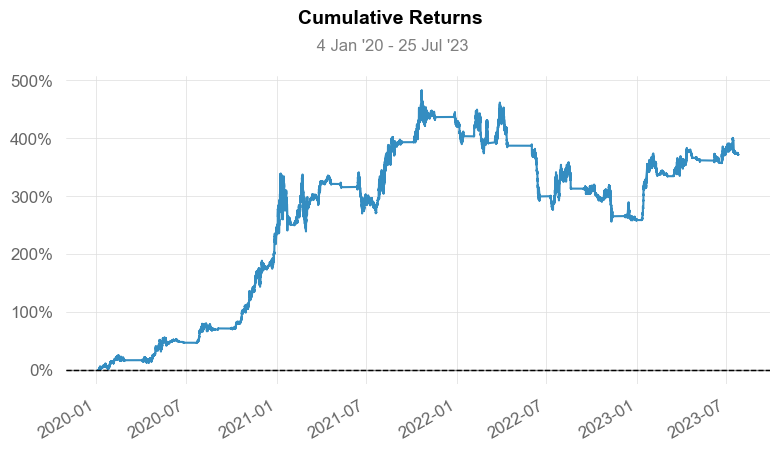

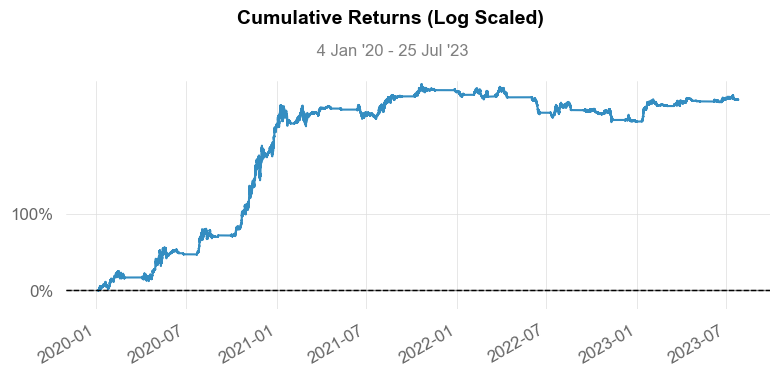

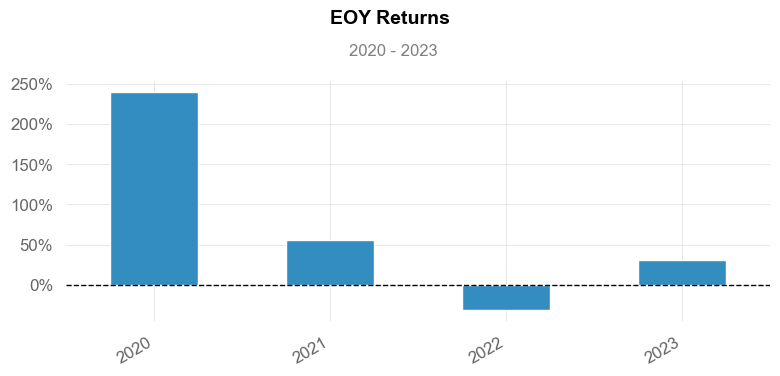

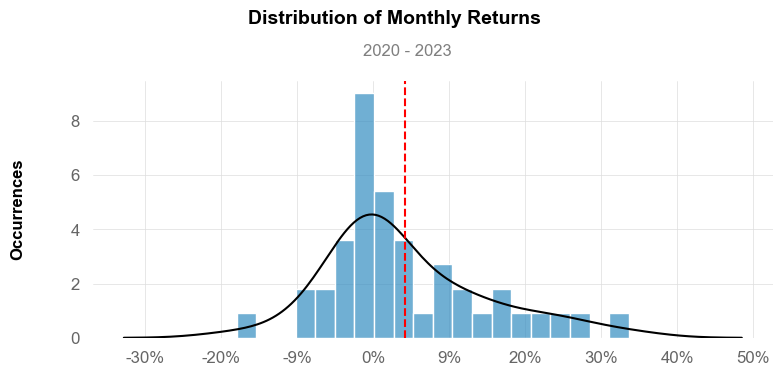

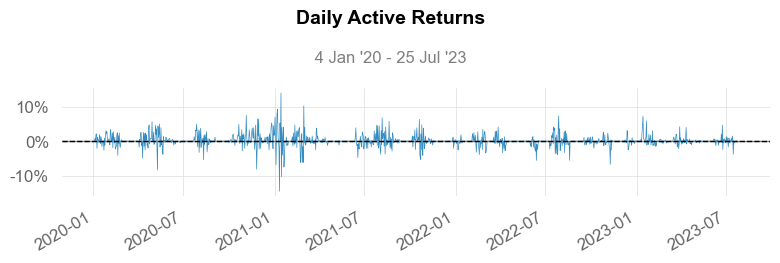

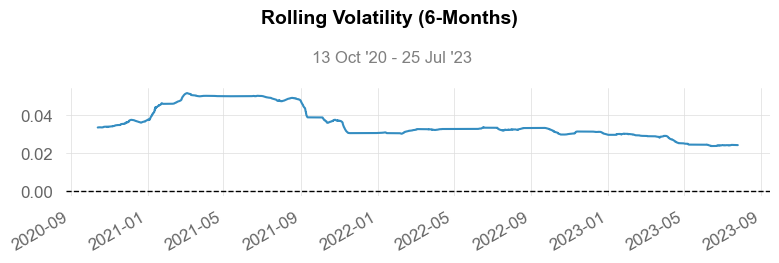

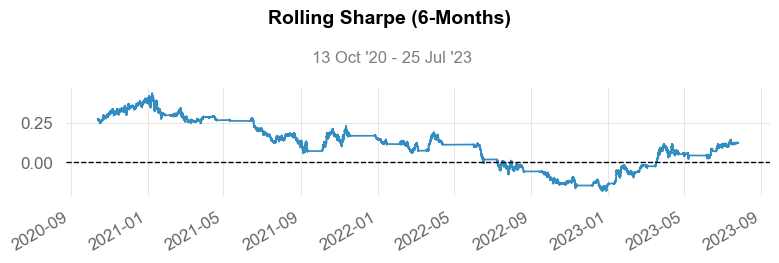

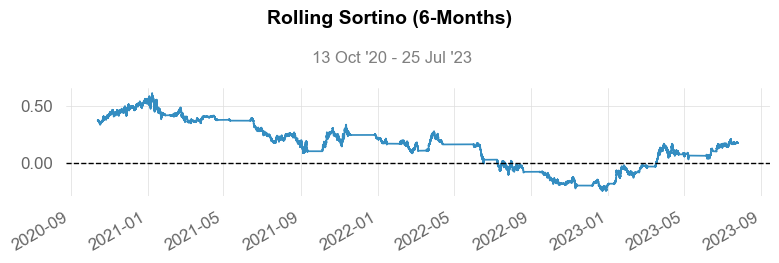

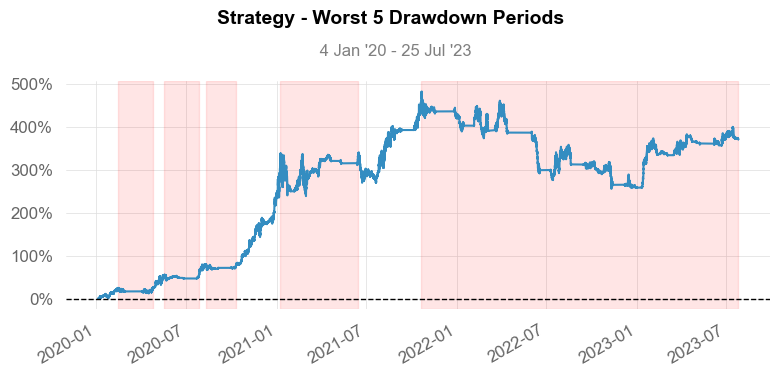

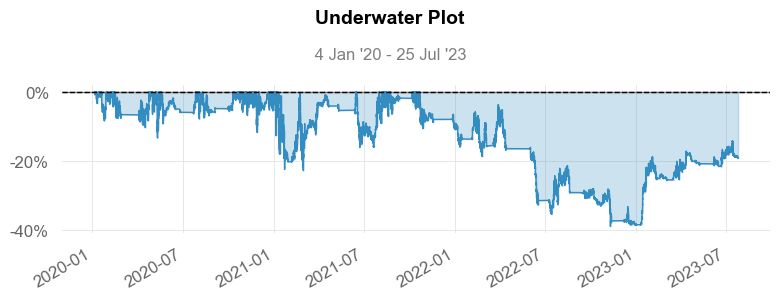

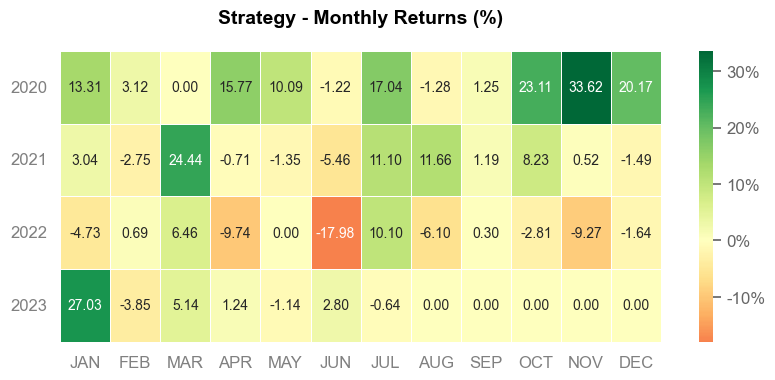

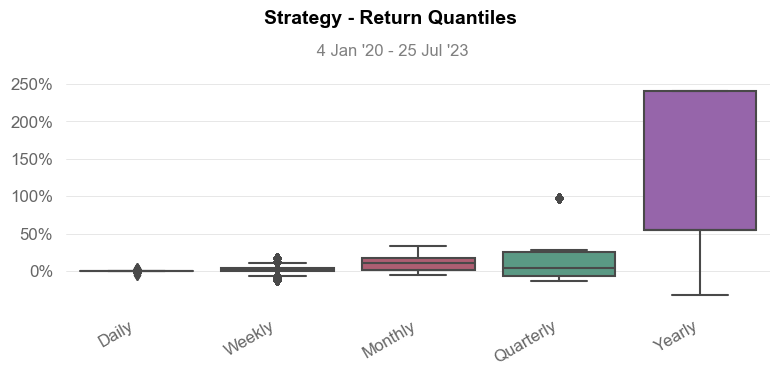

In [72]:
qs.reports.full(
                returns = Strategy_ret,
                rf = 0,periods_per_year=4*24*365,
                compounded = False)

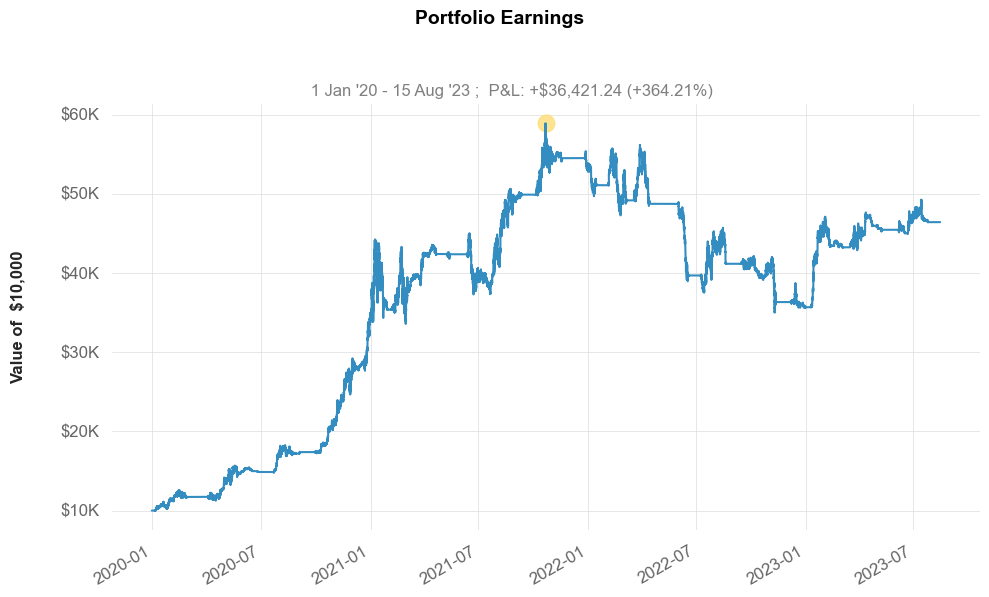

In [116]:
Strategy_ret.plot_earnings(savefig = 'allsample.png',start_balance = 10000)